### Import Library

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import math
import random
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [63]:
X_data = pd.read_csv('dataset/fitur.csv')
X = X_data.values
X

array([[0.5137741 , 0.74558996, 0.78156792, 0.20550526],
       [0.59937033, 0.65895727, 0.78575703, 0.28307523],
       [0.48248721, 0.67346139, 0.80670257, 0.25265383],
       ...,
       [0.48465171, 0.03606429, 0.09694794, 0.0706769 ],
       [0.454939  , 0.24382595, 0.3967684 , 0.07145811],
       [0.67827627, 0.81575853, 0.7432675 , 0.49119985]])

In [64]:
y_data = pd.read_csv('dataset/target.csv')
y = y_data.values
y

array([[0.70550539],
       [0.73579959],
       [0.71103991],
       ...,
       [0.20128168],
       [0.40576755],
       [0.8311972 ]])

### Split Data

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [66]:
X_test = pd.DataFrame(X_test, columns=X_data.columns)
y_test = pd.DataFrame(y_test, columns=y_data.columns)
X_test.to_csv('dataset/X_test.csv', index=False)
y_test.to_csv('dataset/y_test.csv', index=False)

### Modeling

##### Inisialisasi bobot dan bias

In [67]:
def inisialisasi(hidden_layer, hidden_neuron):
    bobot = []
    bias = []
    for i in range(hidden_layer):
        if i == 0:
            bobot.append([[random.uniform(0, 1) for _ in range(hidden_neuron[i])] for _ in range(4)])
        else:
            bobot.append([[random.uniform(0, 1) for _ in range(hidden_neuron[i])] for _ in range(hidden_neuron[i-1])])
        bias.append([random.uniform(0, 1) for _ in range(hidden_neuron[i])])
    bobot_output = [random.uniform(0, 1) for _ in range(hidden_neuron[-1])]
    bias_output = random.uniform(0, 1)
    return bobot, bias, bobot_output, bias_output

##### Fungsi aktivasi

In [68]:
def aktivasiX(activ, x): 
    # aktivasi relu
    if activ == 'relu':
        if x >= 0:
            return x
        else:
            return 0
    # aktivasi sigmoid
    elif activ == 'sigmoid':
        return 1 / (1 + math.exp(-x))
    # aktivasi softmax
    elif activ == 'softmax':
        return 1
    # aktivasi tanh
    else:
        return (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))

def turunanaktivasiX(activ, x): 
    # turunan aktivasi relu
    if activ == 'relu':
        if x > 0:
            return 1
        else:
            return 0
    # turunan aktivasi sigmoid
    elif activ == 'sigmoid':
        sig = 1 / (1 + math.exp(-x))
        return sig * (1 - sig)
    # turunan aktivasi softmax
    elif activ == 'softmax':
        return 0
    # turunan aktivasi tanh
    else:
        tan = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        return 1 - (tan) ** 2

##### Fungsi Training

In [69]:
def ann(epochs, hidden_layer, hidden_neuron, activation, lr, X_train, y_train):
    bobot, bias, bobot_output, bias_output = inisialisasi(hidden_layer, hidden_neuron)
    best_mse = float('inf')
    best_bobot = bobot
    best_bias = bias
    best_bobot_output = bobot_output
    best_bias_output = bias_output
    konstan = 0
    for epoch in range(epochs):
        total_error = 0
        for i in range(len(X_train)):
            # FEEDFORWARD
            # Operasi pada Hidden Layer
            # penjumlahan terbobot dan aktivasi
            aktivasi_hidden = [] # menampung keseluruhan aktivasi
            for j in range(hidden_layer):
                aktivasi_hidden_temp = [] # menampung aktivasi setiap hiden layer (sementara)
                for k in range(hidden_neuron[j]):
                    sumXbobot = 0 # hasil penjumlahan terbobot
                    if j == 0: # untuk hidden neuron pertama (karena neuron input tidak terdefinisi)
                        for l in range(4): # jumlah neuron layer sebelumnya/ neuron input = 4
                            sumXbobot += bobot[j][l][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]): # jumlah neuron layer sebelumnya
                            sumXbobot += bobot[j][l][k] * aktivasi_hidden[j-1][l]
                    # menambahkan bias pada hasil penjumlahan terbobot
                    sumXbobotbias = bias[j][k] + sumXbobot
                    # aktivasi
                    aktivasi_hidden_temp.append(aktivasiX(activation, sumXbobotbias))
                # menambahkan hasil aktivasi tiap hidden_layer ke penampung keseluruhan
                aktivasi_hidden.append(aktivasi_hidden_temp)

            # Operasi pada Output Layer
            # perkalian
            sumZbobotoutput = 0 # hasil penjumlahan terbobot di output layer
            for j in range(hidden_neuron[-1]):
                sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
            # menambahkan bias pada hasil penjumlahan terbobot di output layer
            sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
            # aktivasi
            prediksi = aktivasiX(activation, sumZbobotoutput_biasoutput)

            # Hitung Error (total error untuk menghitung MSE)
            error = y_train[i][0] - prediksi
            total_error += (error ** 2)

        # BACKPROPAGATION
        # error output layer
        error_output = error * turunanaktivasiX(activation, prediksi)
        # inisialisasi error setiap neuron di hidden layer
        error_nuron_hidden = []
        for i in range(hidden_layer):
            error_nuron_hidden.append(np.zeros(hidden_neuron[i]).tolist())
        # error setiap neuron di hidden layer
        for i in range(hidden_layer):
            for j in range(hidden_neuron[-(i+1)]): # mulai dari hidden layer terakhir
                if i == 0: # hidden terakhir akan melibatkan error output
                    sumErrorBobotSetelah = 0
                    sumErrorBobotSetelah += error_output * bobot_output[j]
                    # sum dikalikan turunan input
                    error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunanaktivasiX(activation, aktivasi_hidden[-(i+1)][j]) 
                else:
                    sumErrorBobotSetelah = 0
                    for k in range(hidden_neuron[-(i)]): # hidden layer yang 1 lebihnya
                        sumErrorBobotSetelah += error_nuron_hidden[-(i)][k] * bobot[-(i)][j][k]
                        # sum dikalikan turunan input
                        error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunanaktivasiX(activation, aktivasi_hidden[-(i+1)][j]) 
        # memperbaiki bobot dan bias
        for i in range(len(X_train)):
            for j in range(hidden_layer):
                for k in range(hidden_neuron[j]):
                    # memperbaiki bobot
                    if j == 0:
                        for l in range(4):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * aktivasi_hidden[j-1][l]
                # memperbaiki bias
                bias[j][k] += lr * error_nuron_hidden[j][k]
        # memperbaiki bobot output
        for i in range(len(bobot_output)):
            bobot_output[i] += lr * error_output * aktivasi_hidden[-1][i]
        # memperbaiki bias output
        bias_output += lr * error_output

        # RATA-RATA ERROR
        mse = total_error / len(X_train)
        epoch_sekarang = epoch + 1
        print(f"Epoch {epoch_sekarang}, MSE: {mse}")
        if best_mse > mse:
            best_mse = mse
            best_bobot = bobot
            best_bias = bias
            best_bobot_output = bobot_output
            best_bias_output = bias_output
        elif mse == best_mse:
            konstan +=1
            if konstan == 3:
                print("MSE stabil, PELATIHAN DIHENTIKAN")
                break
    print("PELATIHAN SELESAI\n\n")

    return best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output

##### Training + Tuning

In [70]:
def tuning_hyperparameters(X_train, y_train):
    hidden_layer_values = [1, 2]
    neuron_values = [2, 3, 4]
    aktivasi_values = ['relu', 'sigmoid', 'softmax', 'tanh']
    lr_values = [0.00001, 0.0001, 0.001]
    epoch_values = [100, 200]

    hidden_layer_list = []
    hidden_neuron_list = []
    aktivasi_list = []
    lr_list = []
    epoch_list = []
    mse_list = []
    bobot_list = []
    bias_list = []
    bobot_output_list = []
    bias_output_list = []
    i = 0
    # Looping semua kombinasi
    for hidden_layer in hidden_layer_values:
        # Kombinasi neuron berdasarkan jumlah hidden layers
        for hidden_neuron_combination in itertools.product(neuron_values, repeat=hidden_layer):
            for aktivasi in aktivasi_values:
                for lr in lr_values:
                    for epoch in epoch_values:
                        i += 1
                        print(f"KOMBINASI KE-{i}\nHIDDEN LAYER={hidden_layer}, HIDDEN NEURON={tuple(hidden_neuron_combination)}, AKTIVASI={aktivasi}, LR={lr}, EPOCH={epoch}")
                        mse, bobot, bias, bobot_output, bias_output = ann(epoch, hidden_layer, tuple(hidden_neuron_combination), aktivasi, lr, X_train, y_train)
                        hidden_layer_list.append(hidden_layer)
                        hidden_neuron_list.append(tuple(hidden_neuron_combination))
                        aktivasi_list.append(aktivasi)
                        lr_list.append(lr)
                        epoch_list.append(epoch)
                        mse_list.append(mse)
                        bobot_list.append(bobot)
                        bias_list.append(bias)
                        bobot_output_list.append(bobot_output)
                        bias_output_list.append(bias_output)
    # Menggabungkan list yang ada menjadi dictionary
    data = {
        'hidden_layer': hidden_layer_list,
        'hidden_neuron': hidden_neuron_list,
        'aktivasi': aktivasi_list,
        'lr': lr_list,
        'epoch': epoch_list,
        'mse': mse_list,
        'bobot': bobot_list,
        'bias': bias_list,
        'bobot_output': bobot_output_list,
        'bias_output': bias_output_list
    }
    tuning = pd.DataFrame(data)

    return tuning

##### Pemanggilan fungsi tuning

In [71]:
tuning = tuning_hyperparameters(X_train, y_train)

KOMBINASI KE-1
HIDDEN LAYER=1, HIDDEN NEURON=(2,), AKTIVASI=relu, LR=1e-05, EPOCH=100
Epoch 1, MSE: 3.0445313640280394
Epoch 2, MSE: 2.2900113196530825
Epoch 3, MSE: 1.721672724044224
Epoch 4, MSE: 1.2936731892333566
Epoch 5, MSE: 0.9714531596971339
Epoch 6, MSE: 0.7289560872066001
Epoch 7, MSE: 0.5465353432399601
Epoch 8, MSE: 0.4107677109370172
Epoch 9, MSE: 0.3379512276361268
Epoch 10, MSE: 0.31266227261693197
Epoch 11, MSE: 0.2940970957535089
Epoch 12, MSE: 0.2766509893139131
Epoch 13, MSE: 0.2602561031133422
Epoch 14, MSE: 0.244848722176146
Epoch 15, MSE: 0.23036901307654772
Epoch 16, MSE: 0.21676078599472234
Epoch 17, MSE: 0.20397127149826788
Epoch 18, MSE: 0.19195091112332976
Epoch 19, MSE: 0.18065316088932742
Epoch 20, MSE: 0.17003430693696434
Epoch 21, MSE: 0.16005329253129222
Epoch 22, MSE: 0.1506715557200368
Epoch 23, MSE: 0.1418528769827881
Epoch 24, MSE: 0.13356323624887226
Epoch 25, MSE: 0.12577067870130135
Epoch 26, MSE: 0.11844518882112434
Epoch 27, MSE: 0.1115585721609

##### Visualisasi hasil tuning

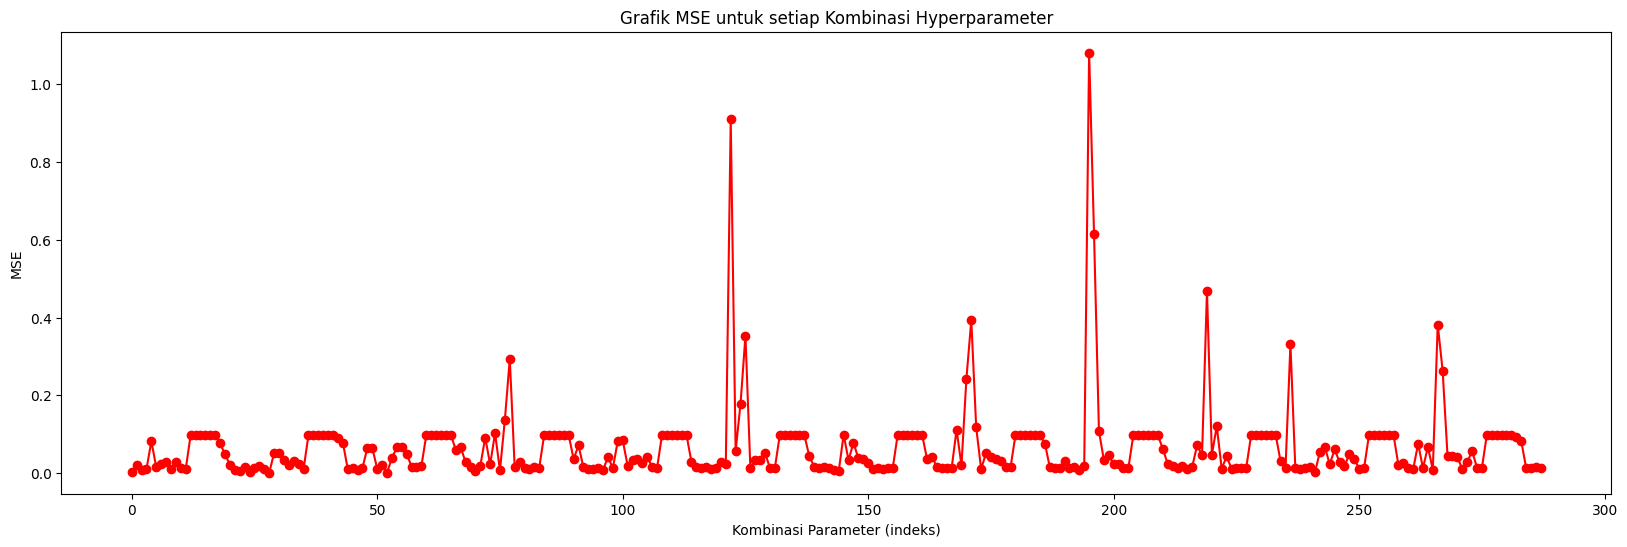

In [72]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(tuning)), tuning['mse'], marker='o', linestyle='-', color='r')
plt.title('Grafik MSE untuk setiap Kombinasi Hyperparameter')
plt.xlabel('Kombinasi Parameter (indeks)')
plt.ylabel('MSE')
plt.show()

In [73]:
tuning.to_csv('hasiltuning.csv', index=False)

In [74]:
tuning

,hidden_layer,hidden_neuron,aktivasi,lr,epoch,mse,bobot,bias,bobot_output,bias_output
0,1,"(2,)",relu,0.00001,100,0.003616,"[[[0.10699418429729088, -0.19550972197236108],...","[[0.572809207821098, -0.013653068291562454]]","[0.6234574260724818, 0.8602252484084684]",0.059012
1,1,"(2,)",relu,0.00001,200,0.021683,"[[[-0.13980825343409117, 0.15353721608257298],...","[[0.27418607228555925, -0.44016591107484504]]","[0.8626237422754499, 0.8164063738540073]",0.803570
2,1,"(2,)",relu,0.00010,100,0.006859,"[[[-0.3377971785796175, 0.14685607514364027], ...","[[0.7100748314478269, -0.7321976046737471]]","[0.5310673728570456, 0.941780353326754]",0.331533
3,1,"(2,)",relu,0.00010,200,0.010269,"[[[0.40518274425828454, -0.38947650023196173],...","[[0.3153681780340243, -0.4282997955760129]]","[0.18454241556813414, 0.910484406339018]",0.652523
4,1,"(2,)",relu,0.00100,100,0.081554,"[[[-3.7256119299037502, -1.0784728357811673], ...","[[0.6035591159166552, -2.0137836647801617]]","[0.7919511051997543, 0.30110559484377547]",0.439488
...,...,...,...,...,...,...,...,...,...,...
283,2,"(4, 4)",tanh,0.00001,200,0.083203,"[[[0.2826365466464155, 0.6100101865619483, -0....","[[0.9113737427963798, 0.973856609016062, 0.637...","[0.9915155316629379, 0.6046935682190382, 0.873...",0.537151
284,2,"(4, 4)",tanh,0.00010,100,0.013800,"[[[0.1985110682361901, -0.009918404190759926, ...","[[0.7774285706745424, 0.7164500242489753, 0.79...","[0.5044970953156604, 0.3503158033658541, 0.770...",0.845093
285,2,"(4, 4)",tanh,0.00010,200,0.012734,"[[[-0.008355418518446327, 0.8648014867112245, ...","[[0.4309213539541634, 0.6873961104254199, 0.42...","[0.1577739035273022, 0.48571907391263036, 0.10...",0.769307
286,2,"(4, 4)",tanh,0.00100,100,0.014646,"[[[0.4972485929988115, -0.14377972034102907, 0...","[[0.5810752836706177, 0.3503533507632055, 0.46...","[0.2463835693924553, 0.9936421229863821, 0.335...",0.456962


In [75]:
best_index = tuning['mse'].idxmin()
best_hidden_layer_global = tuning['hidden_layer'][best_index]
best_hidden_neuron_global = tuning['hidden_neuron'][best_index]
best_lr_global = tuning['lr'][best_index]
best_epoch_global = tuning['epoch'][best_index]
best_mse_global = tuning['mse'][best_index]
best_bobot_global = tuning['bobot'][best_index]
best_bias_global = tuning['bias'][best_index]
best_bobot_output_global = tuning['bobot_output'][best_index]
best_bias_output_global = tuning['bias_output'][best_index]

print("Best Index:", best_index)
print("Best Hidden Layer:", best_hidden_layer_global)
print("Best Hidden Neuron:", best_hidden_neuron_global)
print("Best Learning Rate:", best_lr_global)
print("Best Epoch:", best_epoch_global)
print("Best MSE:", best_mse_global)
print("Best Bobot:", best_bobot_global)
print("Best Bias:", best_bias_global)
print("Best Bobot Output:", best_bobot_output_global)
print("Best Bias Output:", best_bias_output_global)

Best Index: 28
Best Hidden Layer: 1
Best Hidden Neuron: (3,)
Best Learning Rate: 0.001
Best Epoch: 100
Best MSE: 0.000761804359621849
Best Bobot: [[[np.float64(-3.506497907825722), np.float64(1.9697768314244195), np.float64(-0.9240204427783485)], [np.float64(-2.7306406184200447), np.float64(1.9873068834011653), np.float64(-1.2322599781989798)], [np.float64(-3.310959958354285), np.float64(2.495941077204169), np.float64(-0.8517473837460467)], [np.float64(-0.9355686898103772), np.float64(1.4043908560731893), np.float64(0.30766327915648356)]]]
Best Bias: [[0.5263830414299532, 0.9340327119824176, np.float64(-1.8809548645363972)]]
Best Bobot Output: [np.float64(0.8210520159429506), np.float64(0.10923785583848392), np.float64(0.3123763203010679)]
Best Bias Output: 0.11852783594419505
